In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
def get_file_from_drive(folder_id, file_name):
  file_list = drive.ListFile({'q': "'" + folder_id + "' in parents and trashed=false"}).GetList()
  for file in file_list:
    if file['title'] == file_name:
      return file['id']


drive_folder_id = '1oj3k3kGIpqaYfCZpJ2aqV5f3yWzQFeVC'
filename = 'dialog.txt'

def upload_data_system():
  downloaded = drive.CreateFile({'id': get_file_from_drive(drive_folder_id, filename)})
  downloaded.GetContentFile(filename) 





upload_data_system()

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:

data = []
with open('dialog.txt', 'rb') as f:
    for line in f:
        data.append(line.decode(encoding='utf-8', errors='replace')[:-2])





In [ ]:
def make_pair_conversation(data):
    # return list of pair conversation
    pair = []
    for i in range(len(data)-1):
        input = data[i]
        response = data[i+1]
        pair.append([input, response])

    return pair



In [ ]:
pair_convs = make_pair_conversation(data[:100001])

In [ ]:
# A single class for managing all the vocabulary stuff.

pad_token = 0
sos_token = 1
eos_token = 2

class Voc:
    def __init__(self):
        self.trimmed = False
        self.word2index = {'PAD':pad_token, 'SOS':sos_token, 'EOS':eos_token}
        self.word2count = {}
        self.index2word = {pad_token:'PAD', sos_token:'SOS',
                           eos_token:'EOS'}
        self.numword = 3

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.addword(word)

    def addword(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.numword
            self.word2count[word] = 1
            self.index2word[self.numword] = word
            self.numword += 1
        else:
            self.word2count[word] += 1

    def trim(self, min_count):
        """
        based on the wordcount dictionary, keep the words with
        frequency greater than min_count
        """
        if self.trimmed:
            return
        self.trimmed = True
        keep_word = []
        for word, num_freq in self.word2count.items():
            if num_freq >= min_count:
                keep_word.append(word)

        # reinitialize the dictionaries
        self.word2index = {'PAD':pad_token, 'SOS':sos_token, 'EOS':eos_token}
        self.word2count = {}
        self.index2word = {pad_token:'PAD', sos_token:'SOS',
                           eos_token:'EOS'}
        self.numword = 3
        for word in keep_word:
            self.addword(word)

In [ ]:
# Convert (or remove accents) sentence to non_accents sentence
import unicodedata
import re
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

In [ ]:
def normalize_and_voc(pair_convs):
    pairs = [[normalizeString(s) for s in one_pair] for one_pair in pair_convs]
    voc = Voc()
    return voc, pairs

# we ensure sentences must have length smaller than max length
#max_length value is based on our choice, the greater value, 
# the more data training we have and also the more parameter 
# the model have to train on

def filterpair(pairs, max_length):
    """
    Input: pair with format: [input, response],
    we check the length of both input, reponse to identify
    whether or not they are smaller than max length
    return pair with length < max_length
    """
    valid_pair = []
    for pair in pairs:
        input_words, reponse_words = pair[0].split(' '), pair[1].split(' ')
        if len(input_words) < max_length and len(reponse_words) < max_length:
            valid_pair.append(pair)
    return valid_pair


def loadPrepareData(pair_convs, max_length):
    voc, pairs = normalize_and_voc(pair_convs)
    valid_pair = filterpair(pairs, max_length)
    print(f"load total {len(pairs)} pairs")
    print(f"load total {len(valid_pair)} pairs with length <= {max_length}")
    for pair in valid_pair:
        voc.add_sentence(pair[0])
        voc.add_sentence(pair[1])
    print(f"Total number of words in vocab is : {voc.numword}")
    return voc, valid_pair




In [ ]:
voc, valid_pair = loadPrepareData(pair_convs, 25)

load total 100000 pairs
load total 76172 pairs with length <= 25
Total number of words in vocab is : 21366


In [ ]:
for pair in valid_pair[:3]:
    print(pair)

['well i thought we d start with pronunciation if that s okay with you .', 'not the hacking and gagging and spitting part . please .']
['not the hacking and gagging and spitting part . please .', 'okay . . . then how bout we try out some french cuisine . saturday ? night ?']
['okay . . . then how bout we try out some french cuisine . saturday ? night ?', 'you re asking me out . that s so cute . what s your name again ?']


In [ ]:
def trim_rareword(voc, pairs, min_count):
    voc.trim(min_count)
    # trim the voc class with min_count so that every word in 
    # word2index will satisfy min_count freq req
    trimmed_pair = []
    for pair in pairs:
        inp_sent = pair[0]
        resp_sent = pair[1]
        keep_inp = True
        keep_resp = True
        # loop over every word in both inp and resp sentence
        for word in inp_sent.split(' '):
            if word not in voc.word2index: #condition
                keep_inp = False
                break

        for word in resp_sent.split(' '):
            if word not in voc.word2index: #condition
                keep_resp = False
                break

        if keep_inp and keep_resp:
            trimmed_pair.append(pair)

    print(f"The trimming process make the total {len(pairs)} ==> {len(trimmed_pair)} trimmed pair")
    return voc, trimmed_pair

In [ ]:
voc, trimmed_pair = trim_rareword(voc, valid_pair, min_count = 3)

The trimming process make the total 76172 ==> 63291 trimmed pair


In [ ]:
def index_from_sentence(voc, sentence):
    """
    Input: a single sentence
    output: return index resp matching with words in sentence
    based on voc.word2index
    """
    return [voc.word2index[word] for word in sentence.split(' ')] + [eos_token]
    # eos token to indicate sentence ends here

In [ ]:
# test
index_from_sentence(voc, trimmed_pair[5][0])

[64, 10, 65, 6, 57, 66, 67, 50, 68, 15, 15, 15, 2]

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# pads a list of sentences ,l
def zeroPadding(l, fillvalue=pad_token):
    return pad_sequences(l, value=fillvalue, padding='post')

# a binary mask for where there is padding and where there is not
# l is a list of sentences
def binaryMatrix(l, value=pad_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == pad_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m


In [ ]:
def prepared_input(l, voc):
    """
    Purpos: convert to  (returns padded input sequence and lengths)
    """
    indexes_batch = [index_from_sentence(voc, sentence) for sentence in l]
    padded_list_index = zeroPadding(indexes_batch)
    lengths = [len(indexes) for indexes in indexes_batch]
    return padded_list_index, lengths

def prepared_output(l, voc):
    indexes_batch = [index_from_sentence(voc, sent) for sent in l]
    padded_list_index = zeroPadding(indexes_batch)
    max_output_length = max([len(indexes) for indexes in indexes_batch])
    mask = binaryMatrix(padded_list_index)

    return padded_list_index, mask, max_output_length


In [ ]:
# combine all and return all items needed given a batch of pairs
def get_batch_pair(voc, batch_pair):
    """
    sort the len of input sents in desc
    return all input and output items
    """
    # sort len(input sents) in batch_pair with decreasing order
    batch_pair.sort(key = lambda x: len(x[0].split(" ")), reverse = True)

    # divide the batch pair to batch input and batch response
    input_batch, resp_batch = [], []
    for pair in batch_pair:
        input_batch.append(pair[0])
        resp_batch.append(pair[1])

    inp_seq, len_input = prepared_input(input_batch, voc)
    op_seq, mask, max_len = prepared_output(resp_batch, voc)

    return inp_seq, len_input, op_seq, mask, max_len



In [ ]:
inp_seq, len_inp, op_seq, mask, max_len = get_batch_pair(voc, trimmed_pair)

In [ ]:
vocab = voc.word2index

In [ ]:
len(vocab)

12053

In [ ]:
# creating tf.data.Dataset and tuning
BUFFER_SIZE = len(inp_seq)
BATCH_SIZE = 128
steps_per_epoch = len(inp_seq)//BATCH_SIZE
units = 500
maxl = max_len
dataset = tf.data.Dataset.from_tensor_slices((inp_seq, op_seq)).shuffle(BUFFER_SIZE)
dataset = dataset.cache()
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
# tuning region
clip = 50.0
teach_force = 1.0
learning_rate = 3e-4
decoder_learning_rate = 5.0
epochs = 300
enc_layers = 3
dec_layers = 3
drop_prob = 0.1
print_every = steps_per_epoch//7

In [ ]:
ex_input_bt, ex_reply_bt = next(iter(dataset))
ex_input_bt.shape, ex_reply_bt.shape

(TensorShape([128, 25]), TensorShape([128, 25]))

In [ ]:
import numpy as np
import pandas as pd
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {}
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

--2020-08-04 17:19:56--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 2a00:1450:4013:c04::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  61.9MB/s    in 5.3s    

2020-08-04 17:20:01 (61.9 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [ ]:
len(list(embeddings_index.values())[0])

100

In [ ]:
embedding_dim = 100
embeddings_matrix = np.zeros((len(vocab), embedding_dim));
for word, i in vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector
print(f"Made embedding matrix with shape {embeddings_matrix.shape} while finding {int(np.count_nonzero(embeddings_matrix)/100)} out of {len(vocab)-3} words")


Made embedding matrix with shape (12053, 100) while finding 11555 out of 12050 words


In [ ]:
embeddings_matrix.shape

(12053, 100)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, Bidirectional, Concatenate, Dropout, GRU
from tensorflow.keras.initializers import Constant

In [ ]:
# Encoder class for the model
# output: (seq_len, batch, num_dir*hiddensize)
# num_dir = 1 when unidirectional and 2 when bidirectional
class Encoder(Model):
    
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, emb_matrix, num_layers=1, drop_prob = 0):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.embedding = Embedding(vocab_size, embedding_dim, embeddings_initializer=Constant(emb_matrix))
        # multiple number of layers
        self.gru_layers = []
        for i in range(self.num_layers):
            self.gru_layers.append(GRU(self.enc_units, return_state = True, return_sequences=True,
                                    recurrent_initializer='glorot_uniform',
                                    dropout = self.drop_prob))

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru_layers[0](x, initial_state = hidden)
        for i in range(1, self.num_layers-1):
            output, state = self.gru_layers[i](output)
        return output, state 

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))             


In [ ]:
# checking encoder
encoder = Encoder(len(vocab), embedding_dim, units, BATCH_SIZE, embeddings_matrix, num_layers=enc_layers, drop_prob = drop_prob)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(ex_input_bt, sample_hidden)
print(sample_output.shape, sample_hidden.shape)
# output = (batchsize, maxl, units)  (batchsize, units)

(128, 25, 500) (128, 500)


In [ ]:
# creating Attention model
class BahdanauAttention(tf.keras.layers.Layer):

    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, query, values):
        # query is the hidden state to be passes to the decoder shape = (batchsize, hidden_size)
        # values is the output from the gru , shape = (batchsize, max_len, hidden_size)
        # query with time axis is done to broadcast along time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape = (batchsize, maxlen, 1)
        score = self.V( tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
        # self.V converts the shape of scores from (batchsize, maxlen, units) to whatever we have

        # attention weights shape = (batchsize, maxlen, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context vector shape after sum == (batchsize, hiddensize)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(24)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)
print(attention_result.shape, attention_weights.shape)
# output = (batchsize, units) (batchsize, maxl, 1)

(128, 500) (128, 25, 1)


In [ ]:
# creating decoder class
class Decoder(tf.keras.Model):

    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, emb_matrix, num_layers=1, drop_prob=0.1):
        super(Decoder,self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.embedding = Embedding(vocab_size, embedding_dim, embeddings_initializer=Constant(emb_matrix))
        # multiple number of layers
        self.gru_layers = []
        for i in range(self.num_layers):
            self.gru_layers.append(GRU(self.dec_units, return_state = True, return_sequences=True,
                                    recurrent_initializer='glorot_uniform',
                                    dropout = (0 if self.num_layers==1 else self.drop_prob)))
        self.fc = Dense(vocab_size)

        # attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):

        # enc output shape = (batch_sz, maxlen, hiddensize)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after embedding ( batchsize, 1, embedding_dim)
        x = self.embedding(x)
        # x shape after concatenation = (batchsize, 1, embedding_dim + hiddensize)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        # passing the concatenated vector to gru
        output, state = self.gru_layers[0](x, initial_state = hidden)
        for i in range(1, self.num_layers-1):
            output, state = self.gru_layers[i](output)
        # output shape = (batchsize*1, hiddensize)
        output = tf.reshape(output, (-1, output.shape[2]))
        # output shape = (batchsize, vocab)
        x = self.fc(output)

        return x, state, attention_weights


In [ ]:
decoder = Decoder(len(vocab), embedding_dim, units, BATCH_SIZE, embeddings_matrix, num_layers = dec_layers, drop_prob = drop_prob)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)
print(sample_decoder_output.shape)
# output = (batchsize, vocabsize)

(128, 12053)


In [ ]:
# optimizer and loss function
enc_optimizer = tf.keras.optimizers.Adam(lr=learning_rate, 
                                         clipnorm = clip)
dec_optimizer = tf.keras.optimizers.Adam(lr=learning_rate*decoder_learning_rate,
                                         clipnorm = clip)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits = True
)

def loss_fn(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real,0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


In [ ]:

"""# VALIDATION FUNCTIONS

# this function returns the loss for batch size
@tf.function
def validate(inp, rep, enc_hidden):
    
    loss = 0
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([vocab['SOS']]*BATCH_SIZE, 1)

    for t in range(1, rep.shape[1]):
        # passing enc output to decoder
        preds, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
        loss += loss_fn(rep[:,t], preds)

        # checking without teacher forcing
        dec_input = tf.expand_dims(tf.math.argmax(preds, axis=1), 1)


    net_loss = (loss/ int(rep.shape[1]))

    return net_loss
    

# this function takes in the validation splits and runs validate function by giving batch size examples at a time
def validate_over(inp, rep, enc_hidden, batchsize):

    num_batches = inp.shape[0] // BATCH_SIZE
    loss = 0
    for i in range(num_batches):
        inp_tosend = tf.convert_to_tensor(inp[i*BATCH_SIZE : (i+1)*BATCH_SIZE, :])
        rep_tosend = tf.convert_to_tensor(rep[i*BATCH_SIZE : (i+1)*BATCH_SIZE, :])

        loss += validate(inp_tosend, rep_tosend, enc_hidden)

    val_loss = loss / num_batches
    
    return val_loss
"""
    

"# VALIDATION FUNCTIONS\n\n# this function returns the loss for batch size\n@tf.function\ndef validate(inp, rep, enc_hidden):\n    \n    loss = 0\n    enc_output, enc_hidden = encoder(inp, enc_hidden)\n    dec_hidden = enc_hidden\n\n    dec_input = tf.expand_dims([vocab['SOS']]*BATCH_SIZE, 1)\n\n    for t in range(1, rep.shape[1]):\n        # passing enc output to decoder\n        preds, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)\n        loss += loss_fn(rep[:,t], preds)\n\n        # checking without teacher forcing\n        dec_input = tf.expand_dims(tf.math.argmax(preds, axis=1), 1)\n\n\n    net_loss = (loss/ int(rep.shape[1]))\n\n    return net_loss\n    \n\n# this function takes in the validation splits and runs validate function by giving batch size examples at a time\ndef validate_over(inp, rep, enc_hidden, batchsize):\n\n    num_batches = inp.shape[0] // BATCH_SIZE\n    loss = 0\n    for i in range(num_batches):\n        inp_tosend = tf.convert_to_tensor(inp[i*BA

In [ ]:
import random
# one step of train function
teacher_forcing_ratio = teach_force
@tf.function
def train_step(inp, rep, enc_hidden):
    loss = 0

    with tf.GradientTape() as enc_tape, tf.GradientTape() as dec_tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([vocab['SOS']]*BATCH_SIZE, 1)
        
        
        # using teacher_forcing_ratio as a parameter 
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

        if use_teacher_forcing:
            # teacher forcing - feeding the reply as the next input
            for t in range(1, rep.shape[1]):
                preds, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                loss += loss_fn(rep[:,t], preds)
                # teacher forcing
                dec_input = tf.expand_dims(rep[:, t], 1)
                

        else:
            # without teacher forcing using the decoder output as next input
            for t in range(1, rep.shape[1]):
                preds, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                loss += loss_fn(rep[:, t], preds)

                # passing the output
                dec_input = tf.expand_dims(tf.math.argmax(preds, axis=1), 1)
                

                

    batch_loss = (loss/ int(rep.shape[1]))
    
    enc_variables = encoder.trainable_variables
    dec_variables = decoder.trainable_variables

    enc_grads = enc_tape.gradient(loss, enc_variables)
    dec_grads = dec_tape.gradient(loss, dec_variables)

    enc_optimizer.apply_gradients(zip(enc_grads, enc_variables))
    dec_optimizer.apply_gradients(zip(dec_grads, dec_variables))


    return batch_loss


In [ ]:
import time
ep = epochs
losses = []
val_losses = []
num_batches = inp_seq.shape[0] // BATCH_SIZE
for epoch in range(ep):
    print(f"\nSTARTING EPOCH: {epoch+1}")
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    val_loss_batch = []

    for (batch,(inp, rep)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, rep, enc_hidden)
        total_loss += batch_loss
        losses.append(batch_loss)

        if (batch+1)%print_every == 0:
            print("\t Batch {}/{} ===> Train Loss {:.4f}".format(batch+1,num_batches,batch_loss.numpy()))
    
    dataset = dataset.shuffle(BUFFER_SIZE)
    print("Epoch {} completed with Training Loss {:.4f} in {:.4f} sec".format(epoch+1, 
                                                                     total_loss/steps_per_epoch, 
                                                                     time.time() - start)) 
                                                                     
                                                                     
                                                                     
                                                                     
    


STARTING EPOCH: 1
	 Batch 98/494 ===> Train Loss 1.2378
	 Batch 196/494 ===> Train Loss 1.1384
	 Batch 294/494 ===> Train Loss 1.1349
	 Batch 392/494 ===> Train Loss 1.1622
	 Batch 490/494 ===> Train Loss 1.0799
Epoch 1 completed with Training Loss 1.2599 in 195.4475 sec

STARTING EPOCH: 2
	 Batch 98/494 ===> Train Loss 1.1091
	 Batch 196/494 ===> Train Loss 1.1386
	 Batch 294/494 ===> Train Loss 1.0320
	 Batch 392/494 ===> Train Loss 1.0595
	 Batch 490/494 ===> Train Loss 0.9728
Epoch 2 completed with Training Loss 1.0585 in 113.0891 sec

STARTING EPOCH: 3
	 Batch 98/494 ===> Train Loss 1.0768
	 Batch 196/494 ===> Train Loss 1.0907
	 Batch 294/494 ===> Train Loss 0.9701
	 Batch 392/494 ===> Train Loss 0.9090
	 Batch 490/494 ===> Train Loss 1.0372
Epoch 3 completed with Training Loss 1.0046 in 112.3476 sec

STARTING EPOCH: 4
	 Batch 98/494 ===> Train Loss 0.8572
	 Batch 196/494 ===> Train Loss 1.0068
	 Batch 294/494 ===> Train Loss 0.9708
	 Batch 392/494 ===> Train Loss 1.0009
	 Batch

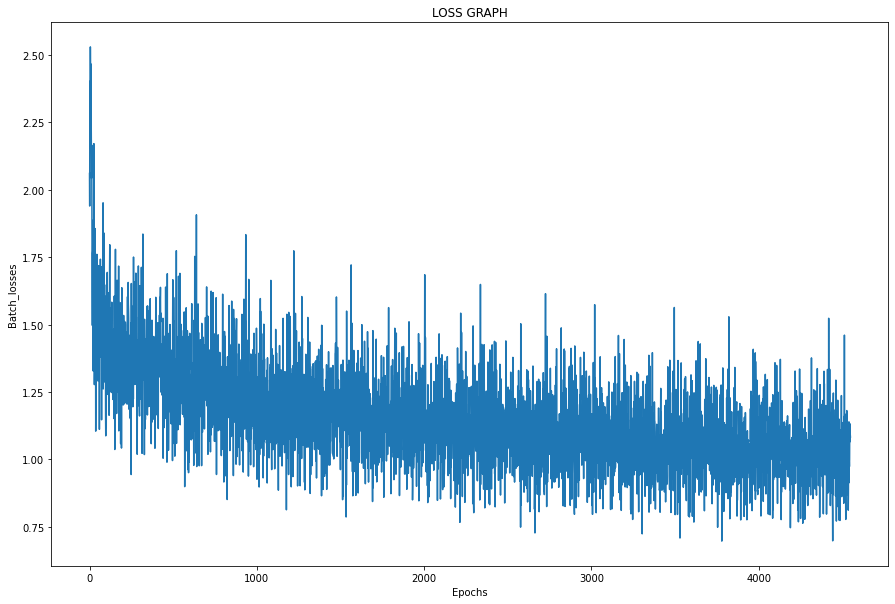

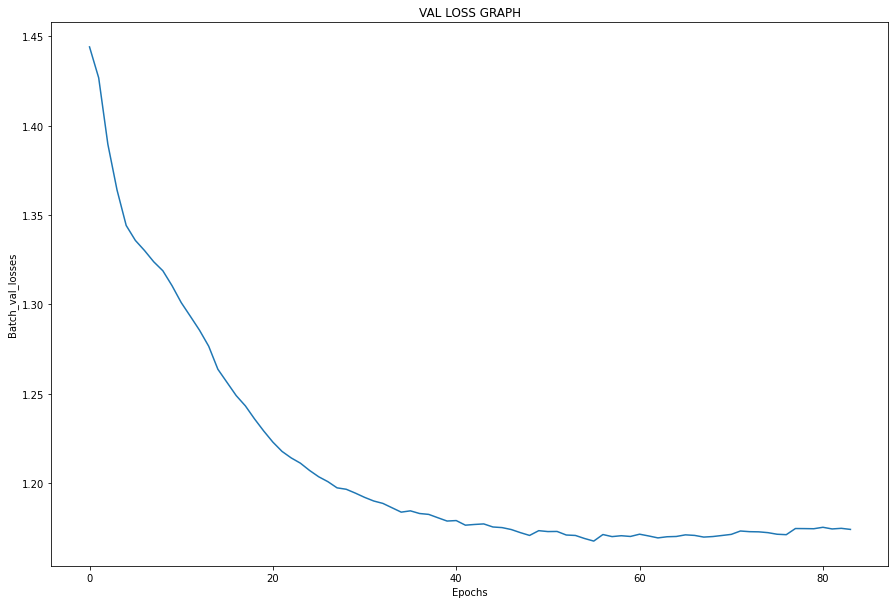

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(losses)
ax.set_xlabel("Epochs")
ax.set_ylabel("Batch_losses")
ax.set_title("LOSS GRAPH")

plt.show()

In [ ]:
# saving your model
encoder.save('encoder.h5')
decoder.save('decoder.h5')
from google.colab import drive
drive.mount('/content/gdrive')
!cp ResNet50_997_940.h5 /content/gdrive/My\ Drive/Colab\ Notebooks

In [ ]:
# evaluate function
def reply_to(sentence):

    sentence = normalizeString(sentence)

    inps = [vocab[word] for word in sentence.split(" ")]
    inps = pad_sequences([inps], maxl , padding='post')
    inps = tf.convert_to_tensor(inps)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inps, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([vocab["SOS"]], 0)

    for t in range(10):
        preds, dec_hidden, attn_wts = decoder(dec_input, dec_hidden, enc_out)

        pred_id = tf.argmax(preds[0]).numpy()

        if inv_vocab[pred_id] == "EOS":
            return result, sentence

        result += inv_vocab[pred_id] + " "

        
        dec_input = tf.expand_dims([pred_id],0)

    return reply

In [ ]:
reply_to("How are you?")


INPUT: <SOM> why am i so bad <EOM>
REPLY: i am not a good 


521